# Minprj : diagnosis of Pneumonia

> date : 9 nov 2021<br>
> author : bae hueng myoung<br>
> email : naroo135@gmail.com

# overview : 

인공지능 기술은 의료분야에서 적용하기 위한 많은 시도가 이루어졌고 일부분 의료분야에서 뛰어난 면모를 갖고 있다. 의료계에 인공지능을 적용하기 위한 수많은 많은 분야 중 가장 괄목한 성과는 데이터를 기반으로 질병의 판별 능력이다. 인공지능을 적용한 모델은 방사선 이미지를 보고 질병의 판독 능력은 인간보다 더 뛰어난 판별 능력을 보여주었고 인공지능을 적용한 환자의 만족도에서 긍정적인 평가를 받았다. 이러한 성과는 인공지능이 다시 붐이 일어나기 전 난제로 여겨지던 기계의 이미지분류의 어려움을 극복하여 현재 특정 이미지 분야에서 사람보다 더 뛰어난 성능을 보여주었다는 점에서 대단히 놀라운 성과이다. 

  이러한 괄목할 만한 이미지 처리의 기술적 성과는 단연 CNN기술의 덕택이다. CNN은 이미지에 convolutional processing을 거쳐 이미지의 특징들을 여러 층에서 추출하고 인공지능의 판별 퍼포먼스를 강화해준다. Conv 처리가 이루어질수록 사람이 알기 어려운 특징들을 추출해내고 해당 추출된 특징들을 통해 모델이 분류 학습을 수행한다. 

In [99]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [100]:
!pwd

/aiffel/aiffel/exp11_chest_xray


In [101]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/exp11_chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/exp11_chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/exp11_chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


In [102]:

## tf.io.gfile.glob make output of file path
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [103]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [104]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/exp11_chest_xray/data/train/NORMAL/NORMAL2-IM-0618-0001.jpeg
Pneumonia image path
/aiffel/aiffel/exp11_chest_xray/data/train/PNEUMONIA/person399_virus_793.jpeg


In [105]:
## counting of 'normal' and pneumonia img num

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [106]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [107]:
len(train_filenames)

4185

In [108]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


## making of label

In [109]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [110]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [111]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [112]:
#check if img and label are combined
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [113]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


## AUGMENTATION

앞선 lms에서 모델의 성능은 95%이상으로 매우 높은 성능을 보였다. 이러한 높은 성능에 대해 이번 프로젝트의 주 목적의 성격을 단번에 없애버리는 결과로 작용한다. 본래 프로젝트의 목적은 cnn의 딥러닝 모델 성능 향상이며 90퍼센트를 달성하는 일이다. 따라서 필자는 프로젝트의 본래 목적이 상실된 현재 augmentation이 얼마나 효과적인지 실험해 볼 것이다.

In [114]:
## not implementation of augmentation
def prepare_for_training_orig(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds_orig = prepare_for_training_orig(train_ds)
val_ds_orig = prepare_for_training_orig(val_ds)

In [115]:
## implemation of augmentation

def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training_aug(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_aug = prepare_for_training_aug(train_ds)
val_ds_aug = prepare_for_training_aug(val_ds)

In [116]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

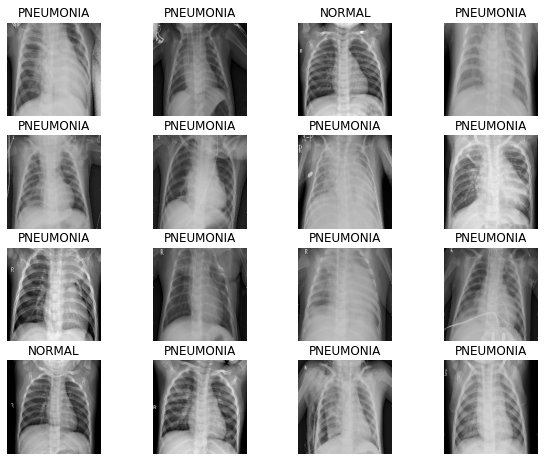

In [117]:
# not aug
image_batch, label_batch = next(iter(train_ds_orig))
show_batch(image_batch.numpy(), label_batch.numpy())

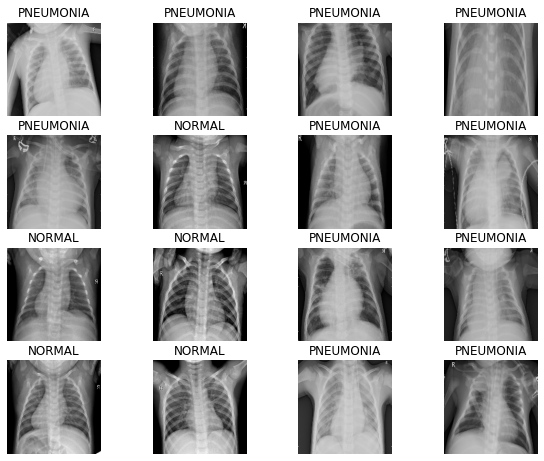

In [118]:
# aug
image_batch, label_batch = next(iter(train_ds_aug))
show_batch(image_batch.numpy(), label_batch.numpy())

#### 위의  결과물을 보면 항상  가슴  왼쪽에 있는 심장의 위치가 바뀌어 있는 사진들이 보인다. 이는 augmentation을 통해 좌우 반전처리가 되었기 때문이다.

## CNN mdeling

In [119]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [120]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [121]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [122]:
# weight_for_0 is for normal img
# weight_for_1 is for pneumonia img

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## model training

#### model 1 : not aug, imbalance applying

In [123]:
with tf.device('/GPU:0'):
    model_orig_imb = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_orig_imb.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

#### model 2: not aug, imbalance not applying

In [124]:
with tf.device('/GPU:0'):
    model_orig_notimb = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_orig_notimb.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

#### model 3: aug, imb applying

In [125]:
with tf.device('/GPU:0'):
    model_aug_imb = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_aug_imb.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

#### model 4: aug, not imb applying

In [126]:
with tf.device('/GPU:0'):
    model_aug_notimb = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_aug_notimb.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

#### model fitting
orders : model_orig_imb, model_orig_notimb, model_aug_imb, model_aug_notimb

In [129]:
with tf.device('/GPU:0'):
    history = model_orig_imb.fit(
        train_ds_orig,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_orig,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )
    
    
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

Epoch 1/25
261/261 [==============================] - 74s 246ms/step - loss: 0.2504 - accuracy: 0.9033 - precision: 0.9711 - recall: 0.8967 - val_loss: 1.1432 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 64s 244ms/step - loss: 0.2071 - accuracy: 0.9207 - precision: 0.9767 - recall: 0.9155 - val_loss: 0.4198 - val_accuracy: 0.8096 - val_precision: 1.0000 - val_recall: 0.7402
Epoch 3/25
261/261 [==============================] - 64s 247ms/step - loss: 0.1861 - accuracy: 0.9289 - precision: 0.9772 - recall: 0.9259 - val_loss: 0.9459 - val_accuracy: 0.7577 - val_precision: 0.7520 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 64s 245ms/step - loss: 0.1812 - accuracy: 0.9306 - precision: 0.9806 - recall: 0.9250 - val_loss: 0.0851 - val_accuracy: 0.9663 - val_precision: 0.9892 - val_recall: 0.9645
Epoch 5/25
261/261 [==============================] - 65s 249ms/step - loss: 0.1655 - accura

KeyboardInterrupt: 

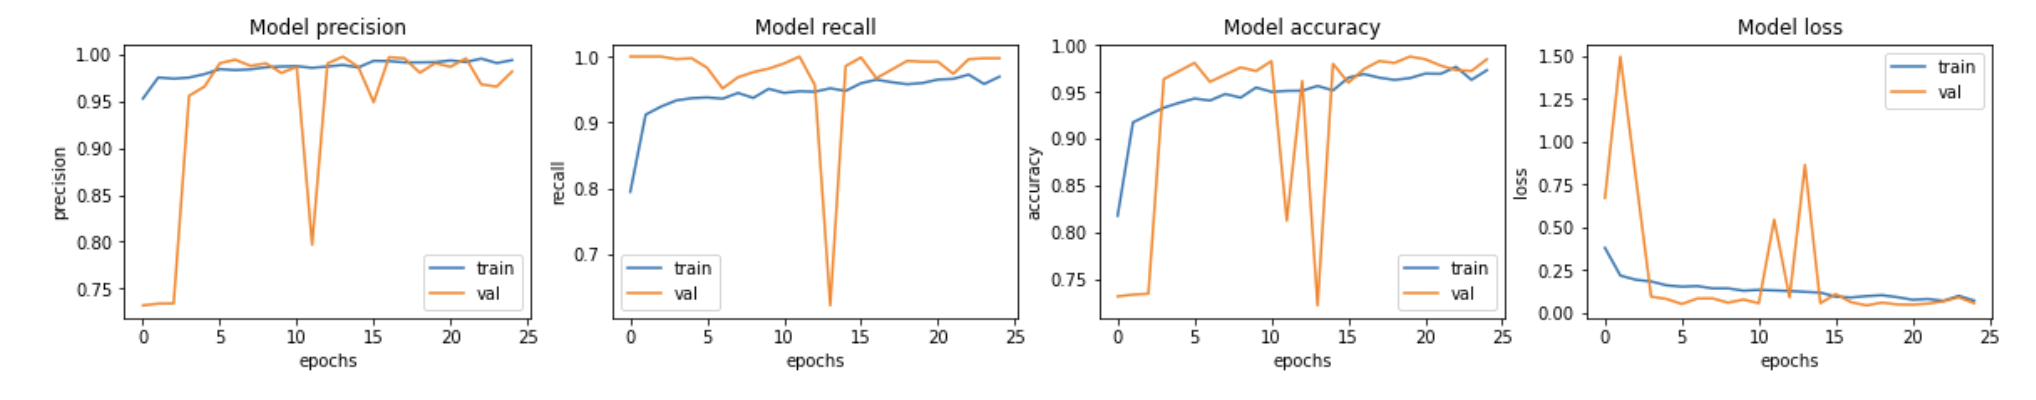

In [132]:
from IPython.display import Image
Image("orig.png")

#### 시간 관계상 lms그대로 학습하였을 때의 결과물이다. 이 결과물에서 정확도와 recall값은 대단히 좋은 성능을 보인다.

In [130]:
with tf.device('/GPU:0'):
    history = model_orig_notimb.fit(
        train_ds_orig,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=15,
        validation_data=val_ds_orig,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        #class_weight=class_weight,
    )
    
    
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

Epoch 1/15
261/261 [==============================] - 76s 245ms/step - loss: 0.6147 - accuracy: 0.7000 - precision: 0.8694 - recall: 0.7063 - val_loss: 0.8210 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/15
261/261 [==============================] - 61s 235ms/step - loss: 0.2257 - accuracy: 0.9199 - precision: 0.9511 - recall: 0.9409 - val_loss: 1.1614 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/15
261/261 [==============================] - 62s 238ms/step - loss: 0.1692 - accuracy: 0.9395 - precision: 0.9564 - recall: 0.9631 - val_loss: 0.8221 - val_accuracy: 0.7423 - val_precision: 0.7401 - val_recall: 1.0000
Epoch 4/15
261/261 [==============================] - 64s 244ms/step - loss: 0.1802 - accuracy: 0.9331 - precision: 0.9461 - recall: 0.9645 - val_loss: 0.1296 - val_accuracy: 0.9510 - val_precision: 0.9395 - val_recall: 0.9974
Epoch 5/15
  2/261 [..............................] - ETA: 26s - loss: 0.0848 - accuracy: 0.

KeyboardInterrupt: 

In [ ]:
with tf.device('/GPU:0'):
    history = model_aug_imb.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_aug,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )
    
    
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
with tf.device('/GPU:0'):
    history = model_aug_notimb.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_aug,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        #class_weight=class_weight,
    )
    
    
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## recall

이제까지 모델 성능에 대해서 대부분 accuracy에 의존적이었다. accuracy가 높으면 높으면 높을수록 모델이 잘 학습했다고 판단해왔다. 하지만 의료 부분에서 특정 질병을 진단할 때 특정 질병에 대해서 normal(이상없음)으로 잘못 진단하는 것에 대해 대단히 민감해야 한다.
따라서 폐렴을 진단하는 이번 프로젝트에서 recall의 수치에 대한 평가기준으로 모델의 학습이 잘 진행되었는지 판단하여야 한다.

## how to enhance performance CNN model

모델의 성능은 validation과 train의 loss, accuracy의 그래프를 통해 직관적으로 알아볼 수 있다. 이 모델이 epoch에 따라 overfitting 혹은 underfitting하는지 trend를 확인하여 모델 훈련의 적합성을 판단할 수 있다. 이러한 퍼포먼스는 얼마나 모델이 적정한 weight값을 업데이트 하느냐에 따라 달라진다. 괄목할 만한 분류성능을 나타내기 위한 최적의 weight값들을 찾고 튜닝하는 것은 대단히 어려운 일이다. 그 이유는 모델의 각 레이어들에서 벌어지는 파라미터들의 연산량은 단순히 몇개로만 이루어지지 않기 때문이다. 
하지만 cs231n에서 backpropogation의 기법으로 가장 낮은 loss를 지향하며 weight값을 업데이트하는 방식은 모델 성능 개선에 유용하며 사람의 개입없이 자동적으로 수행되는 장점이 있다. 하지만 비선형처리에서 발생하는 적절하지 않은 backpropogation은 모델의 성능 개선을 뒷걸음치게 만든다. 예를 들면 'sigmoid' activation function에서 saturated된 값은 gradient가 0에 수렴하며 이는 레이어를 거칠 때 마다 loss에 대한 weight의 gradient가 0로 만드는 vanishing현상을 일으킨다. 이러한 문제를 해결하기 위해서 batch normalization과 같은 기법으로 해결할 수 있으며 


<__모델 성능을 높이기 위한 방법들__><br>
데이터의 다양성 - augmentation applying <br>
back propogation의 적합성 - activation을 tanh와 같은 다른 function으로 교체, BN기법 <br>
앙살블 기법 <br>
hyper parameter tunning - grid search 기법<br>
정도를 고려해볼 수 있다.


# feedback
여러가지 시도를 통해 모델 학습의 개선을 확인해보고 싶었으나 시간 관계상 많은 시도를 하지 못했다. 
